# Tutorial of how to use bmplot module 
By Gregory Glickert
## Generate example bmtk network
First we will generate an example BMTK network to then use the functions on

In [1]:
from bmtk.builder import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_cuboid,positions_list,xiter_random
from bmtool.connectors import ReciprocalConnector, UnidirectionConnector, GapJunction, OneToOneSequentialConnector, syn_section_PN, syn_dist_delay_feng

import numpy as np
import os

if os.path.isfile("conn.csv"):
    os.remove("conn.csv")

# cell count
num_of_PN = 250
num_of_FSI = 50
# generate rand postions
postions = positions_cuboid(num_of_PN+num_of_FSI,min_dist=10)

# select locations 
inds = np.random.choice(np.arange(0, np.size(postions, 0)), num_of_PN, replace=False)
pos = postions[inds, :]
net = NetworkBuilder('bio_net')
net.add_nodes(N=num_of_PN, 
              pop_name='PN',
              positions=positions_list(pos),
              model_type='biophysical',
              rotation_angle_xaxis = xiter_random(N=num_of_PN, min_x=-np.pi, max_x=np.pi),
              rotation_angle_yaxis = xiter_random(N=num_of_PN, min_x=-np.pi, max_x=np.pi),
              rotation_angle_zaxis= xiter_random(N=num_of_PN, min_x=-np.pi, max_x=np.pi),
              morphology=None)
# Get rid of coordinates already used
postions = np.delete(postions, inds, 0)

inds = np.random.choice(np.arange(0, np.size(postions, 0)), num_of_FSI, replace=False)
pos = postions[inds, :]
net.add_nodes(N=num_of_FSI, 
              pop_name='FSI',
              positions=positions_list(pos),
              model_type='biophysical',
              rotation_angle_xaxis = xiter_random(N=num_of_FSI, min_x=-np.pi, max_x=np.pi),
              rotation_angle_yaxis = xiter_random(N=num_of_FSI, min_x=-np.pi, max_x=np.pi),
              rotation_angle_zaxis= xiter_random(N=num_of_FSI, min_x=-np.pi, max_x=np.pi),
              morphology=None)

background = NetworkBuilder('background')
background.add_nodes(N=300,
                   pop_name='background_nodes',
                   potential='exc',
                   model_type='virtual')


Now lets build som example connections using bmtool's connection module 

In [2]:
connector = UnidirectionConnector(p=0.10,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

connector = ReciprocalConnector(p0=0.22,p1=0.36,pr=0.17,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(**connector.edge_params())

connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

connector = UnidirectionConnector(p=0.30,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(**connector.edge_params())

connector = GapJunction(p=0.10,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(is_gap_junction=True,**connector.edge_params())

connector = OneToOneSequentialConnector(verbose=False)
connector.setup_nodes(source=background.nodes(), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())
connector.setup_nodes(target=net.nodes(pop_name = 'FSI'))
net.add_edges(**connector.edge_params())

net.save('network/')
background.save('network/')


from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='./',      
                network_dir='network/',
                tstop=3000.0, dt=0.1,
                spikes_inputs=[('background', 
                                'background.h5')], 
                include_examples=False,    
                compile_mechanisms=False,   
                config_file='config.json',
                overwrite_config=True
                )



## How bmplot Works

In general, bmplot functions take the following inputs:

- `config`: Path to a BMTK config file  
- `sources`: Name of the source network  
- `targets`: Name of the target network  
- `sids`: Source IDs  
- `tids`: Target IDs  

These inputs are used to generate plots. Additional optional inputs can be provided to refine and clean up the output.

`config`
- A path to the BMTK configuration file.

`sources` and `targets`
- The name of the source and target network you'd like to analyze.

- In this example generated above a network called `bio_net` and a network called `background`

`sids`and `tids`
- The node attribute you want the nodes separted by when generating the plot

- In this example above valid options are `pop_name`, `positions`, `model_type`, `rotation_angle_xaxis`, `rotation_angle_yaxis`, `rotation_angle_zaxis`, and `morphology`.




## Total_connection_matrix
generates a matrix with the number of total connections between sid and tid pairs.

numprocs=1


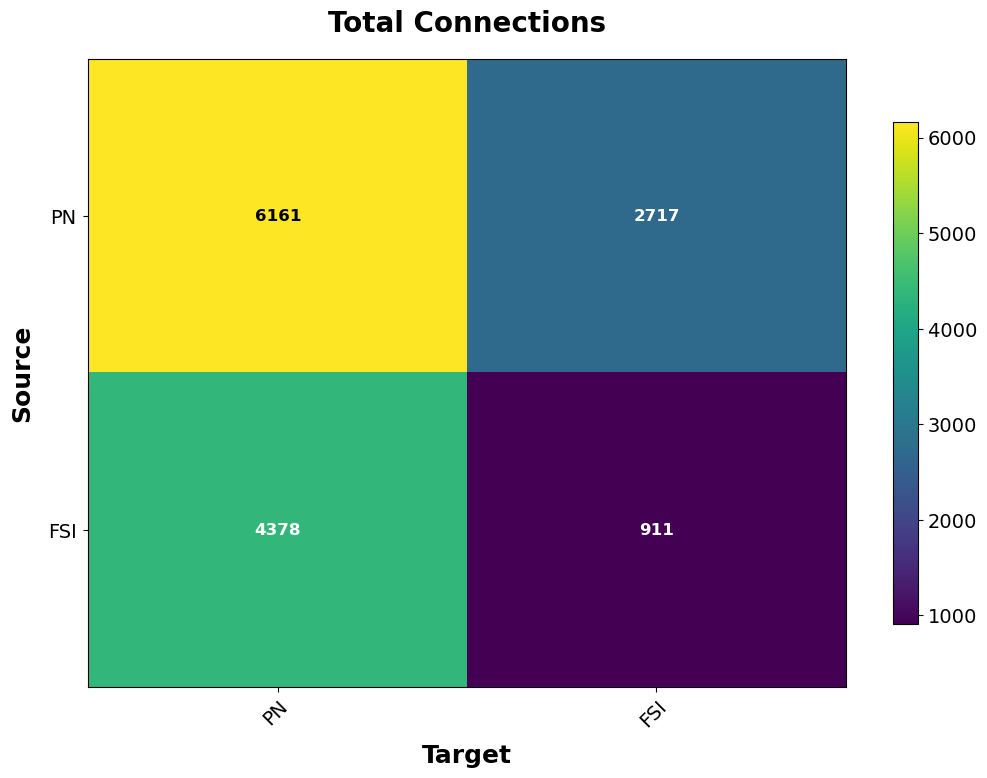

In [3]:
from bmtool.bmplot import connections as bp
import matplotlib.pyplot as plt
%matplotlib inline
bp.total_connection_matrix(config='config.json',
                           sources='bio_net', 
                           targets='bio_net', 
                           tids='pop_name', 
                           sids='pop_name', 
                           no_prepend_pop=True,# if the network source or target should be added to the name or not
                           include_gap=True # if there are gap junctions in the network should they be included or not in the connection number
                           )
plt.show()

## convergence_connection_matrix
generate a matrix with the average and standard deviation of the convergence. Convergence is how many of sid cells connection to a single tid cell.

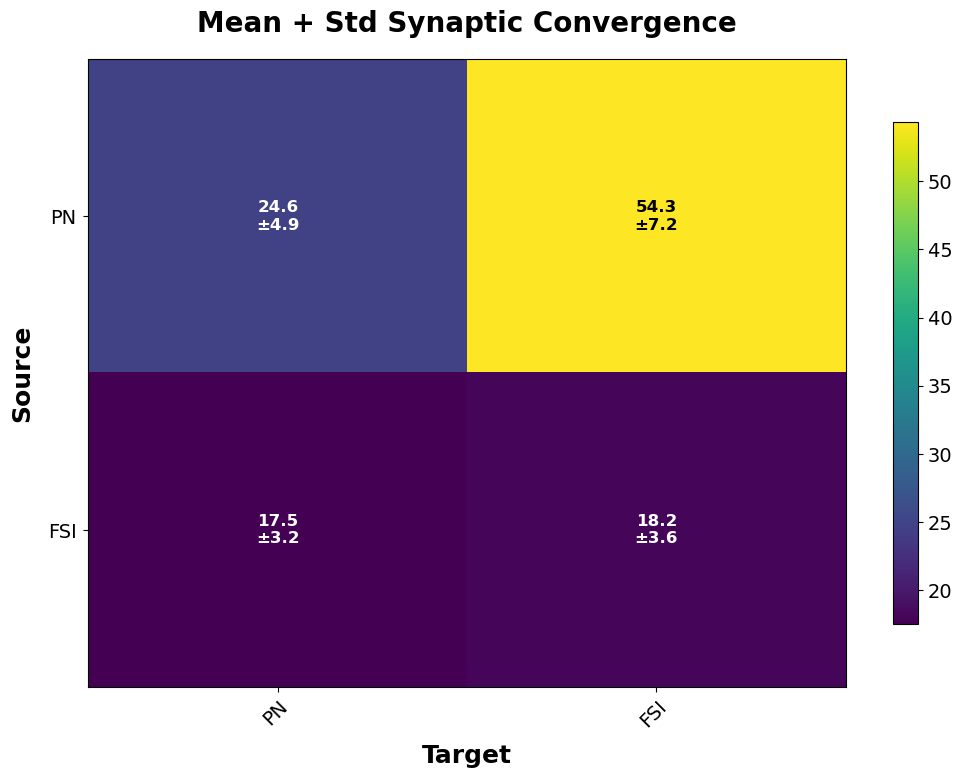

In [4]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.convergence_connection_matrix(**kwargs)
plt.show()

There are also different methods that can be used. The current methods are 'mean','min','max','stdev' or 'mean+std'. By default the function will use 'mean+std' like above, but you can specify a method like below. In the example below min means display the convergence value that is the smallest in the whole network for those sid and tid pairs.

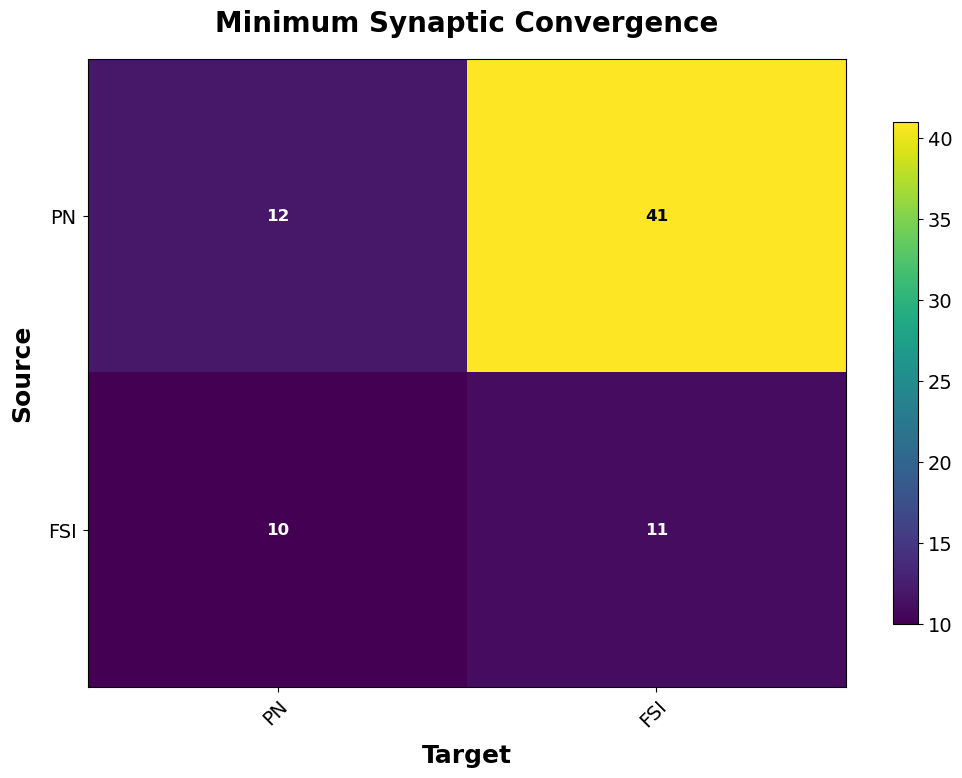

In [5]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.convergence_connection_matrix(method='min',
                                 **kwargs)
plt.show()

## connection dictionary 
You can also have the some of the bmplot functions return a dictionary with the connection data. This can be helpful making tables and graphs out of the data. Below is an example function that generates a dataframe from the dictionary and then plots the data. This feature could be helpful for generating custom graphs. 

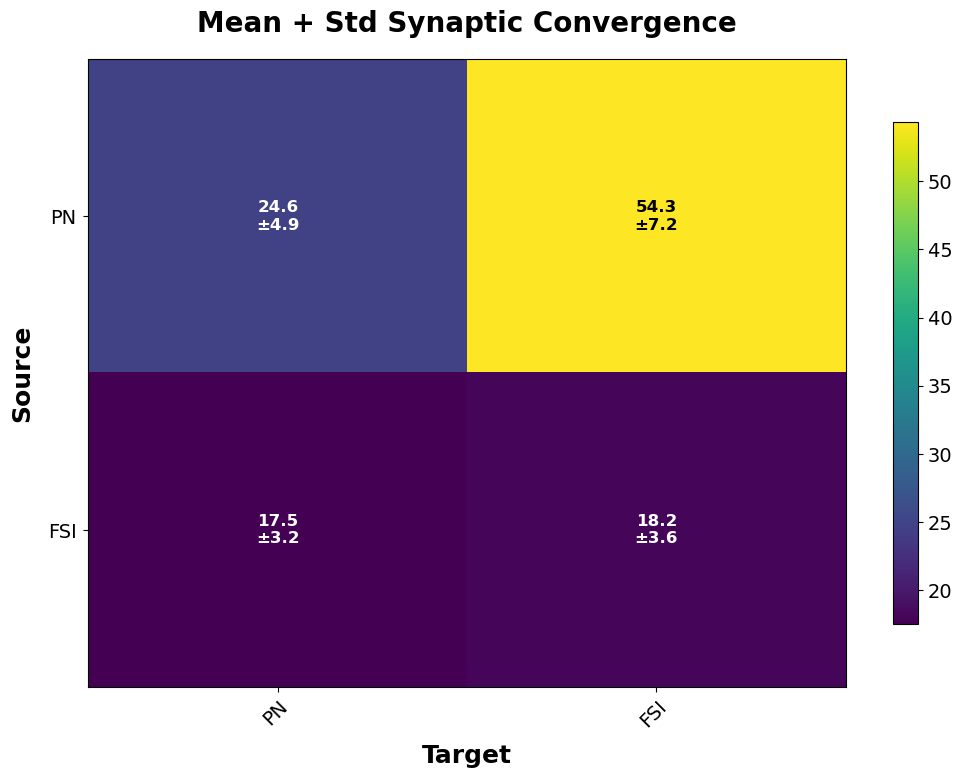

,PN,FSI
PN,24.6,54.3
FSI,17.5,18.2


In [6]:
import pandas as pd

bio_net_convergence = bp.convergence_connection_matrix(return_dict=True,**kwargs)
plt.show()

def gen_edge_df(dict):
    # Get the unique labels (source and target)
    source_labels = list(dict.keys())
    target_labels = list(next(iter(dict.values())).keys())

    # Initialize a matrix to store mean and std values
    matrix_mean = np.full((len(source_labels), len(target_labels)), np.nan)
    matrix_std = np.full((len(source_labels), len(target_labels)), np.nan)

    # Create a mapping from label to index for source and target
    source_index = {source_labels[i]: i for i in range(len(source_labels))}
    target_index = {target_labels[i]: i for i in range(len(target_labels))}

    # Fill the matrices with mean and std values
    for source in source_labels:
        for target in target_labels:
            edge_info = dict.get(source, {}).get(target, 'nan\nnan')
            
            # Check if the edge_info is 'nan\nnan' or valid
            if edge_info != 'nan\nnan':
                mean, std = map(float, edge_info.split('\n'))
                matrix_mean[source_index[source], target_index[target]] = mean
                matrix_std[source_index[source], target_index[target]] = std

    # Convert the matrices to pandas DataFrame for better visualization
    df_mean = pd.DataFrame(matrix_mean, index=source_labels, columns=target_labels)
    df_std = pd.DataFrame(matrix_std, index=source_labels, columns=target_labels)

    return df_mean, df_std

mean_df, std_df = gen_edge_df(bio_net_convergence)
display(mean_df)

## divergence_connection_matrix 
works the same as the convergence only calculates a different metric. Divergence is a count of how many tids the a given sid cell will go and connect into.

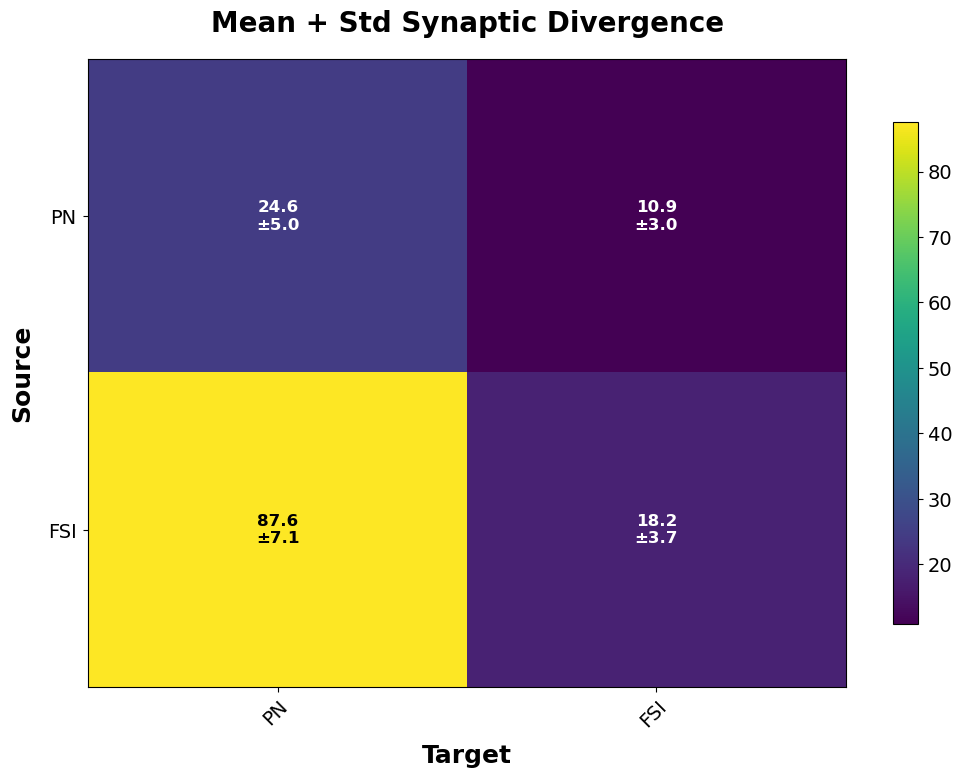

In [7]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.divergence_connection_matrix(**kwargs)
plt.show()

## gap_junction_matrix
generate a matrix only showing the connectivity of gap junctions formed in the network. Method can be either convergence or percent

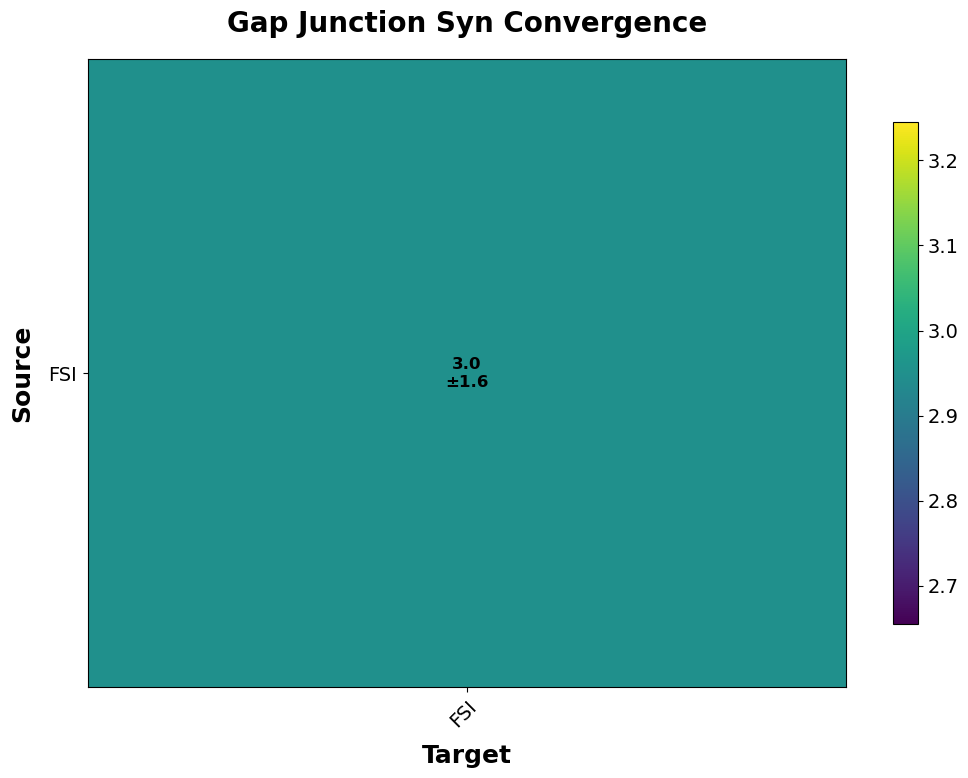

In [8]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.gap_junction_matrix(method='convergence',
                       **kwargs)
plt.show()

## connection_histogram 
plots the number of connections individual cells in a population receive from another population. The source_cell and target_cell must both be valid strings in sid and tid. In the example below pop_name is used for the sids and tids and "PN" and "FSI" are valid pop_names in our network

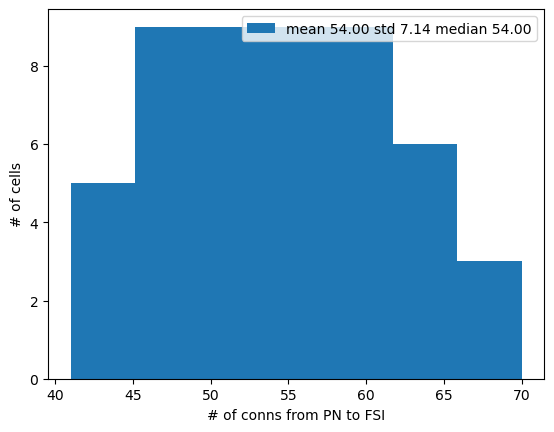

In [9]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.connection_histogram(source_cell='PN', # must be one of the Node attribute
                        target_cell='FSI',
                        **kwargs)
plt.show()

## percent_connection_matrix 
generates a matrix of percent connectivity in the network. This percent connectivity does not factor in distance and instead looks at the whole percent connectivity of the population. There are three methods either 'uni', 'bi' or 'total'. 'uni' means unidirectional percent connectivity,'bi' means the bidirectional connectivity and 'total' is both added together.

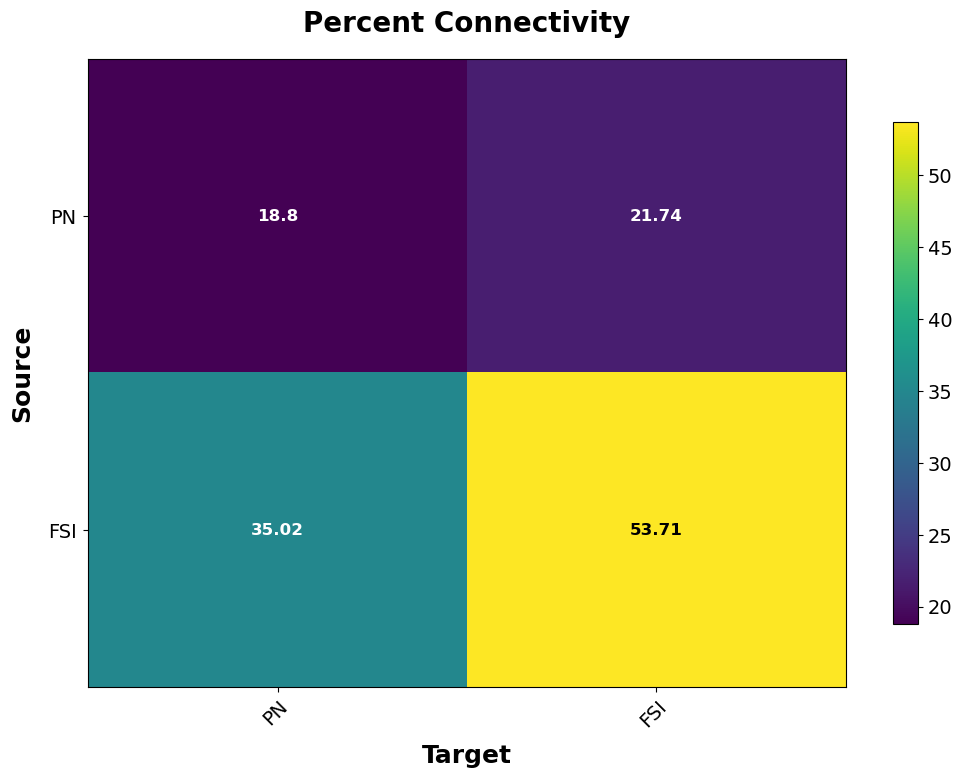

In [10]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.percent_connection_matrix(method='total', # should match the p in the build network above roughly
                             include_gap=False,
                             **kwargs)
plt.show()

## connector_percent_matrix 
uses the report generated by the bmtool.connectors module to plot the percent connectivity. However this report will show the percent connectivity from possible connections within the connection rule. This makes it the only way to look at percent connectivity of a network while factoring in distance

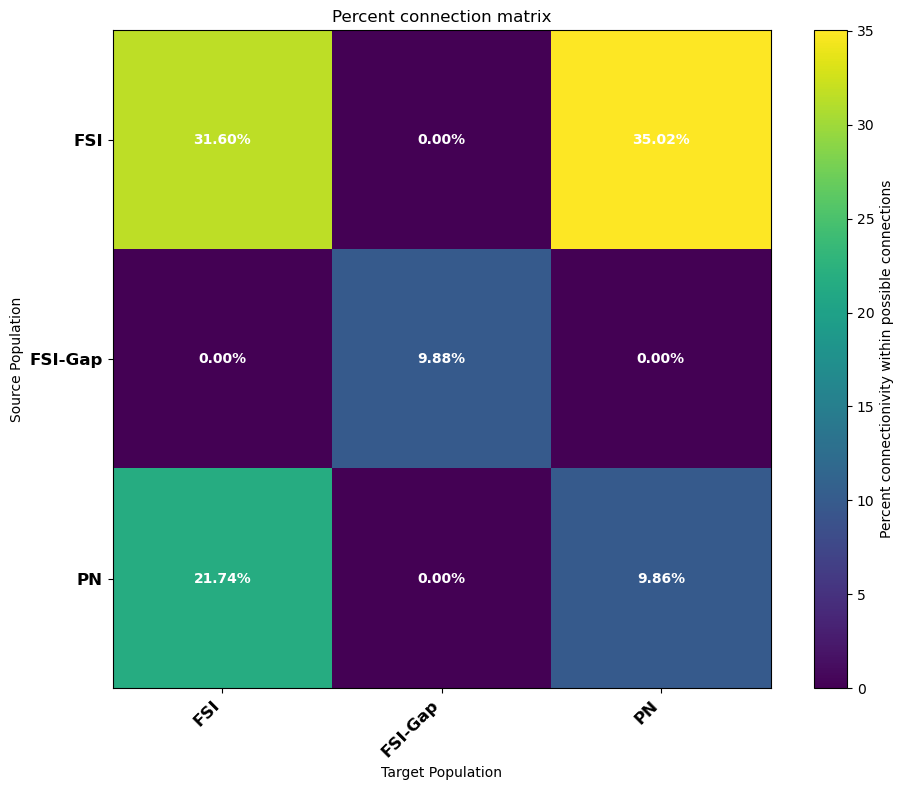

In [11]:
bp.connector_percent_matrix(csv_path="conn.csv") # path to csv generated by connectors
plt.show()
                            

We can see that plot does not look the same as the other percent connectivity or the other plots we have made with the order of the ticks. This can all be adjusted

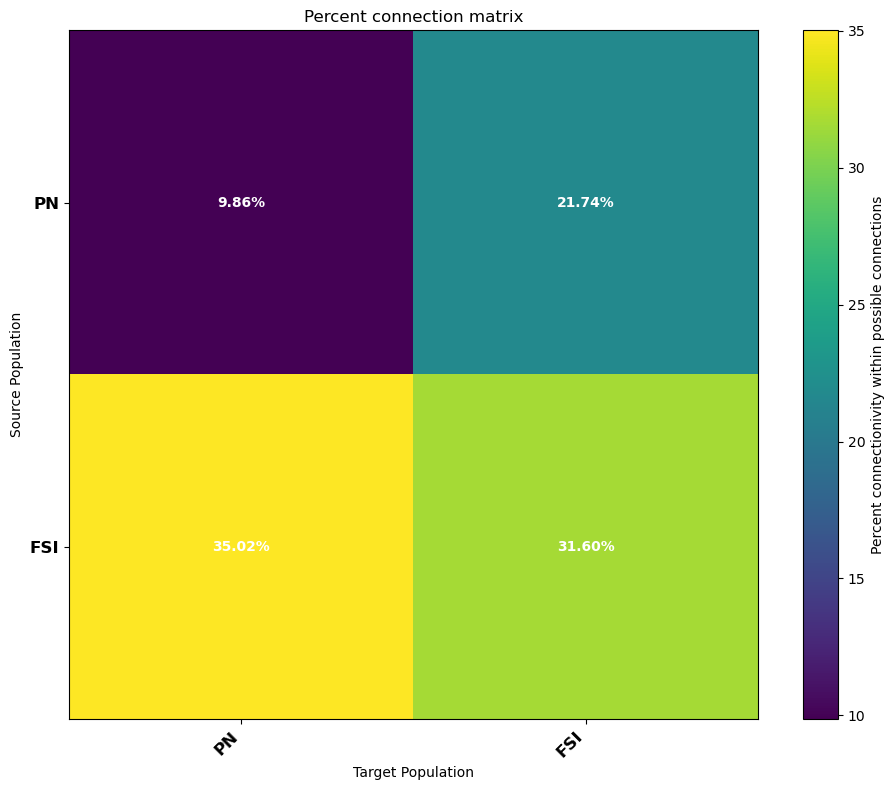

In [12]:
bp.connector_percent_matrix(csv_path="conn.csv", #
                            exclude_strings=['Gap'], # ignores gap junction can be used to ignore any string 
                            pop_order=['PN','FSI']) # order of x and y ticks
plt.show()

## connection_distance 
shows the location of the source and target cells along with the distance between the cells.

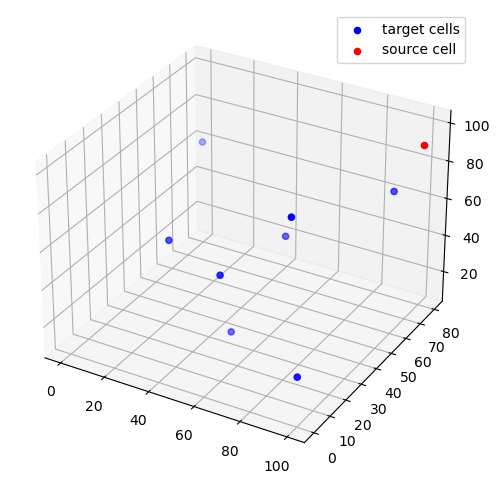

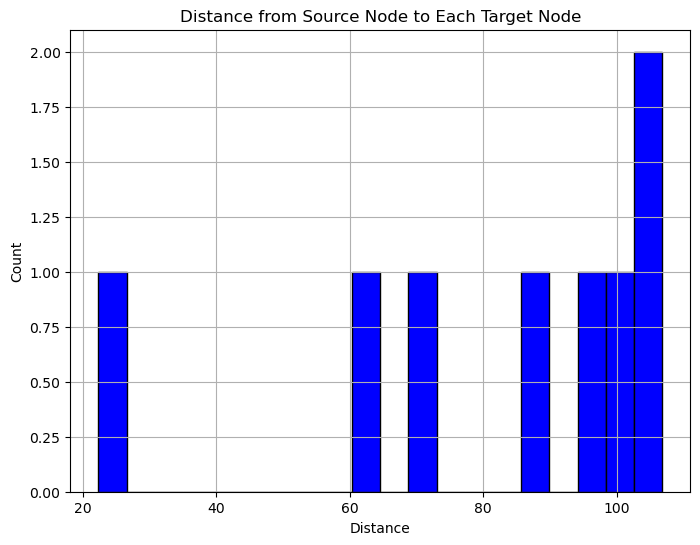

In [13]:
bp.connection_distance(config='config.json',
                       sources='bio_net',
                       targets='bio_net',
                       source_cell_id=1, # node_id 
                       target_id_type='FSI', # pop_name of cells can be left empty for all cells
                       ignore_z=False) # some connection rules can ignore the z axis
plt.show()

## Between network analysis
Currently the demo has only shown the biophysical connectivity, but bmplot can display any combo of networks connectivity by switching the sources,targets,sids, and tids

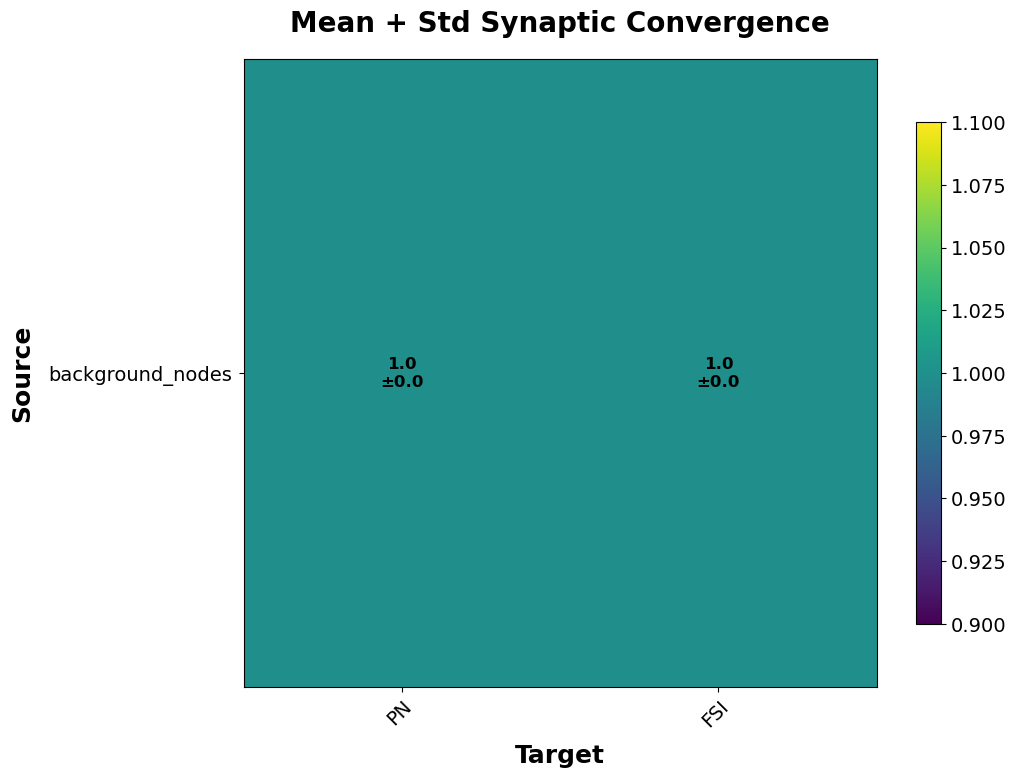

In [14]:
kwargs = {'config':'config.json',
          'sources': 'background', # note the difference here
          'targets': 'bio_net',
          'sids': 'pop_name',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.convergence_connection_matrix(**kwargs)
plt.show()

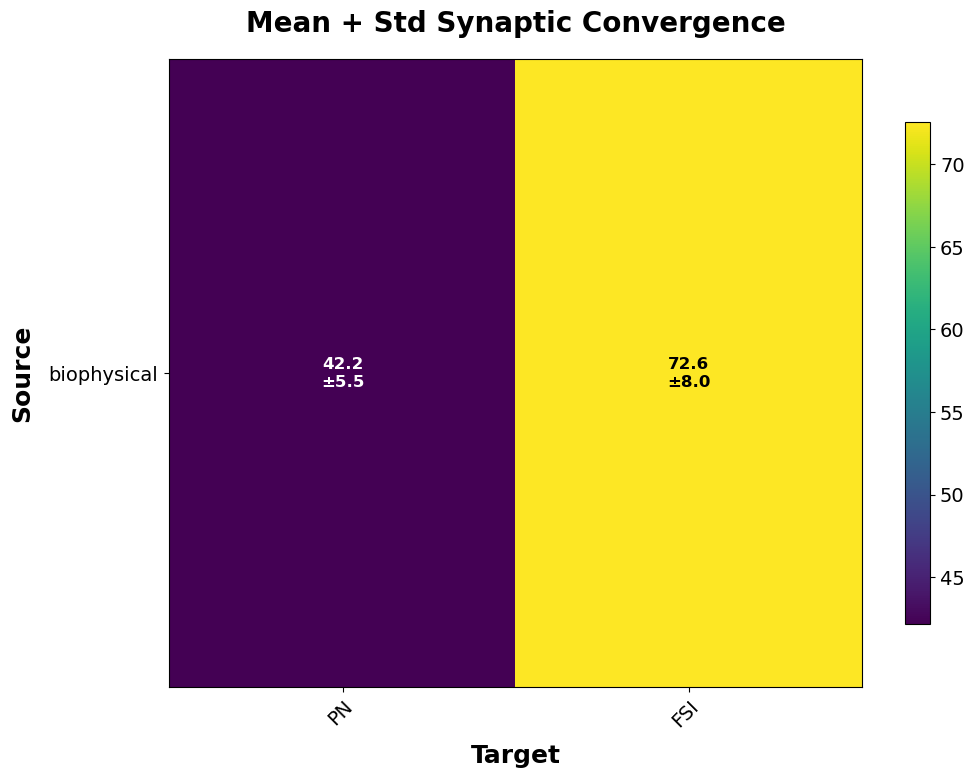

In [15]:
kwargs = {'config':'config.json',
          'sources': 'bio_net', 
          'targets': 'bio_net',
          'sids': 'model_type',
          'tids': 'pop_name',
          'no_prepend_pop':True}
bp.convergence_connection_matrix(**kwargs)
plt.show()

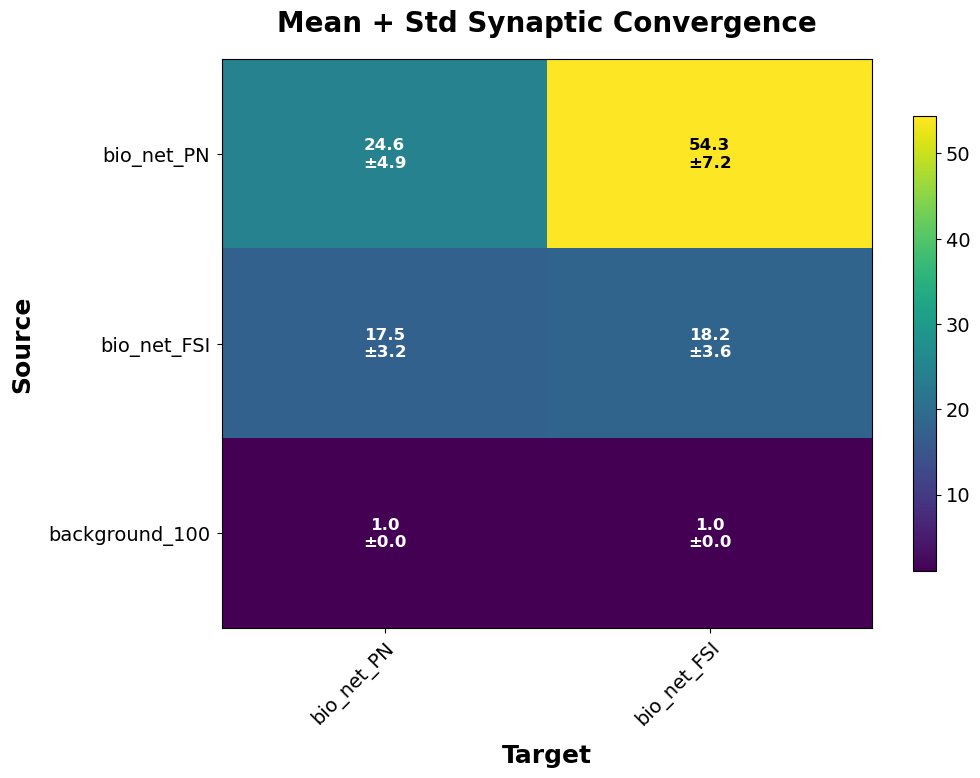

In [16]:
kwargs['sids'] = 'pop_name'
kwargs['sources'] = 'all'
kwargs['targets'] = 'all'
kwargs['no_prepend_pop'] = False
bp.convergence_connection_matrix(**kwargs)
plt.show()

## plot_3d_positions 
takes similar arguments to the previously shown bmplot functions and will generate a 3d plot of where the nodes are located in the network 

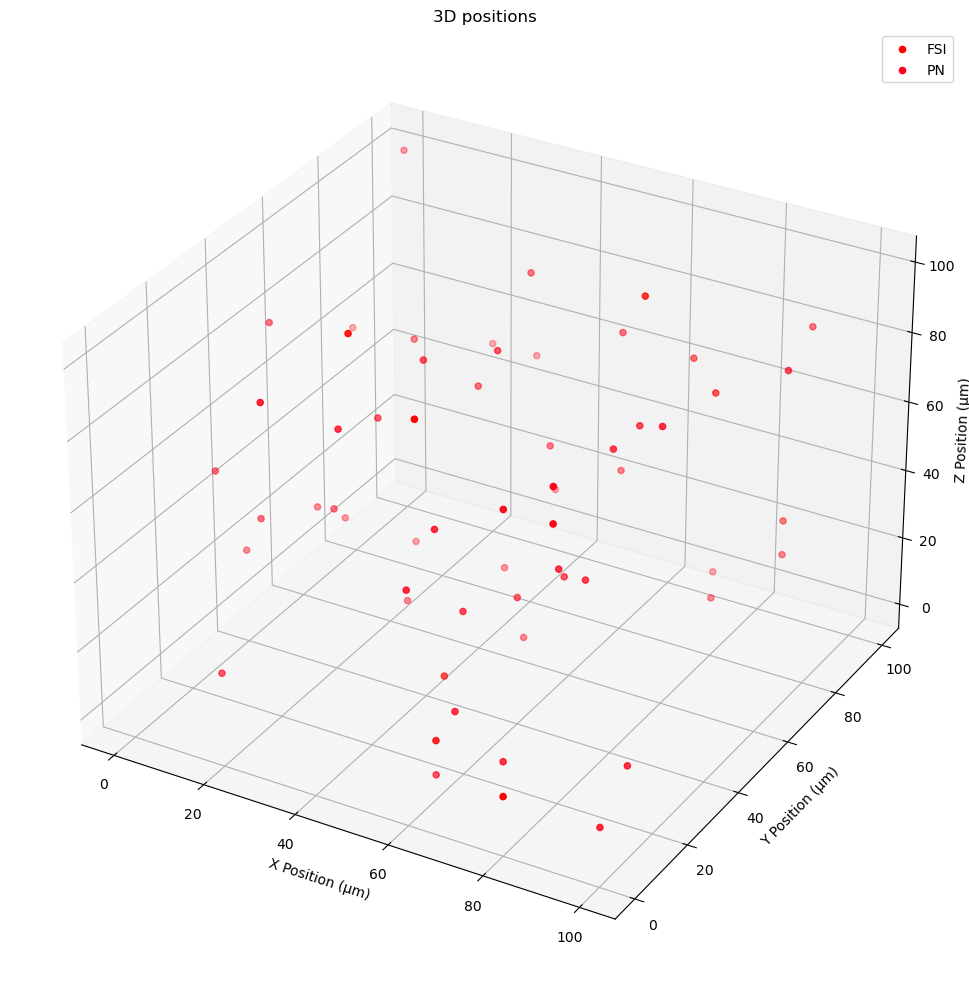

In [17]:
bp.plot_3d_positions(config='config.json', 
                     sources='bio_net', 
                     sid='pop_name', 
                     subset=5 # how many nodes in each pop you want to plot so 5 means take every 5th row and plot it good for extremely large networks
                     )
plt.show()

## plot_3d_cell_rotation 
will plot the rotation of the neuron in 3d space. 

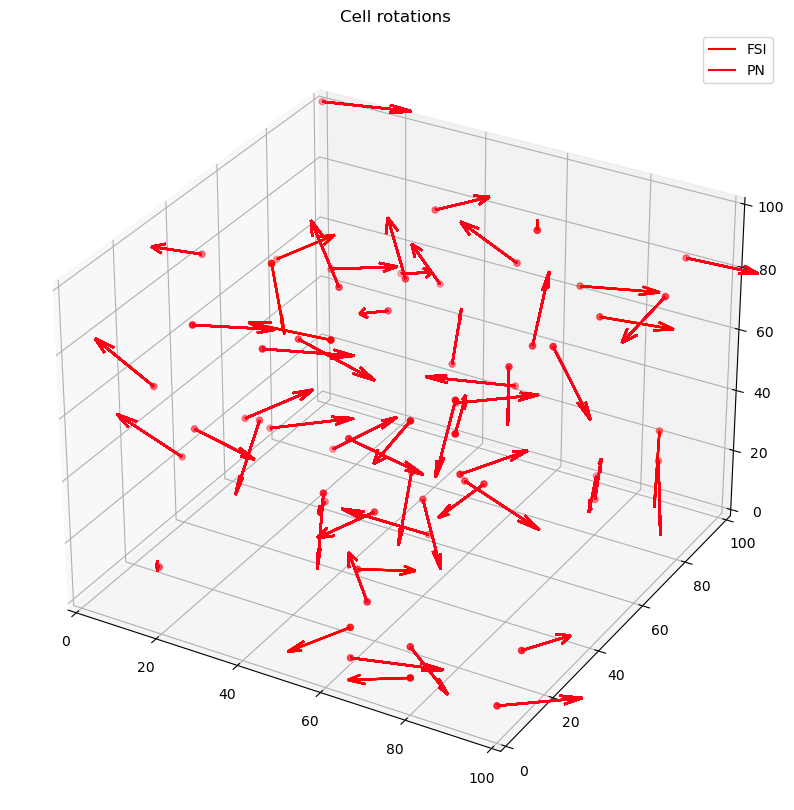

In [18]:
bp.plot_3d_cell_rotation(config='config.json',
                         sources='bio_net',
                         sids='pop_name',
                         quiver_length=20,
                         arrow_length_ratio=0.25,
                         subset=5)
plt.show()